In [ ]:
a = []
while(1):
  a.append("1")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, Flatten, Convolution2D, AveragePooling2D, MaxPooling2D, Dense
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.utils.data_utils import get_file
#from keras.application.imagenet_utils import preprocess_input
import pydot
#import IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
#import scipy, misc
from matplotlib.pyplot import imshow

import random
import pickle
import cv2
import os

In [ ]:
dataset = pd.read_csv("ahlast.csv")


data = []

channel = 3
img_width, img_height = 224, 224

path = '/content/drive/MyDrive/Hepsi'

In [ ]:
for i in range(len(dataset)):
    try:
        class_num = dataset["Zaman Farkı"][i]

        data.append([cv2.resize(
                        cv2.imread(
                            os.path.join(path, dataset["new_name"][i]), 
                            cv2.IMREAD_COLOR), 
                        (img_height,img_width)),
                    class_num])
    except Exception as e:
            pass

In [ ]:
a = np.array(data)
a.shape



In [ ]:
x = []
y_names = []
for features, labels in data:
    x.append(features)
    y_names.append(labels)

y_names = np.array(y_names)
x = np.array(x).reshape(-1, img_height, img_width, channel)
x.shape, y_names.shape

In [ ]:
a = np.array(y_names)
a.shape

In [ ]:
y = []

for i in y_names:
    if i < 94:
        y.append(0)
    elif i >= 94 and i < 165:
        y.append(1)
    elif i >= 165 and i <= 202:
        y.append(2)
    elif i > 202 and i < 285:
        y.append(3)
    elif i >= 285:
        y.append(4)

In [ ]:
a = np.array(y)
a.shape

In [ ]:
y = to_categorical(y=y, num_classes=5, dtype='float32')
y.shape

In [ ]:
import pickle

pickle_out = open("/content/drive/MyDrive/x.pickle", "wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
import pickle

with open("/content/drive/MyDrive/x.pickle", "rb") as pickle_in:
  images = pickle.load(pickle_in)

with open("/content/drive/MyDrive/y.pickle", "rb") as pickle_in:
  Y = pickle.load(pickle_in)

In [ ]:
images.shape, Y.shape

((19696, 224, 224, 3), (19696, 5))

Sanırım categorical_crossentropy, adam, softmax, relu standard olarak kullanıklıyor değil mi?

relu bir activation, ara layerın sonunda kullanılıyor. diğerlerine göre daha iyi sonuç veriyor çünkü pozitif tarafta çıktı neyse onu dönüyor. pozitif tarafın gradient'ı da 1 olduğu için backpropagation kısmınsa gradient vanishing'e yardım ediyor. araştırmanı öneririm.

softmax toplamı 1 yapıyor olasılık gibi, genelde sonda kullanılıyor bu yüzden

adam bir optimizer, momentum'u falan otomatik ayarladığı için ve basit olduğu için daha rahat anlaşılıyor ve kullanılıyor.

cc ise loss, birden fazla sınıf için sınıflandırma yapcaksan kullanılıyor

direk tf documentationdan bakabilirsin hepsine, çok standard şeyler


In [ ]:
images, Y = shuffle(images, Y)
# random_states = 1

train_x, test_x, train_y, test_y = train_test_split(images, Y, random_state = 415)

y_score = []
 
for i in test_y:
    if i[0] == 1.0:
        y_score.append(0)
    elif i[1] == 1.0:
        y_score.append(1)
    elif i[2] == 1.0:
        y_score.append(2)
    elif i[3] == 1.0:
        y_score.append(3)
    elif i[4] == 1.0:
        y_score.append(4)
 
y_score = np.array(y_score)



def identity_block(X, f, filters):
    #F1 = 64
    #F2 = 64
    #F3 = 256
    F1, F2, F3 = filters

    X_shortcut = X

    X = Convolution2D(filters = F1, kernel_size = (1,1), strides = (1 ,1), padding="valid")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)

    X = Convolution2D(filters = F2, kernel_size = (f,f), strides = (1 ,1), padding="same")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)

    X = Convolution2D(filters = F3, kernel_size = (1,1), strides = (1 ,1), padding="valid")(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

def convolutional_block(X, f, filters, s=2):

    F1, F2, F3 = filters

    X_shortcut = X

    X = Convolution2D(filters = F1, kernel_size = (1,1), strides = (s ,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)

    X = Convolution2D(filters = F2, kernel_size = (f,f), strides = (1 ,1), padding="same")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)

    X = Convolution2D(filters = F3, kernel_size = (1,1), strides = (1 ,1), padding="valid")(X)
    X = BatchNormalization(axis = 3)(X)

    X_shortcut = Convolution2D(filters = F3 , kernel_size = (1,1), strides = (s,s), padding="valid")(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

def ResNet50(input_shape = (224, 224, 3), classes = 5):

    # define the input shape with input_shape
    X_input = Input(input_shape)

    # zero_padding
    X = ZeroPadding2D((3,3))(X_input) #3,3 padding

    # stage 1
    X = Convolution2D(filters = 64, kernel_size =  (7,7), strides = (2,2))(X)
    #X = Convolution2d(filters = 64, kernel_size = (7, 7), strides = (2 ,2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation("relu")(X)
    x = MaxPooling2D((3,3), strides=(2,2))

    # stage 2
    X = convolutional_block(X, f = 3, filters = [64,64,256], s=1)
    X = identity_block(X , 3, [64, 64, 256])
    X = identity_block(X , 3, [64, 64, 256])

    # stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # stage 5
    X = convolutional_block(X, f = 3, filters = [512, 128, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVG POOL

    X = AveragePooling2D((2,2), name = "avg_pool")(X)

    X = Flatten()(X)

    X = Dense(classes, activation = "softmax", name = "fc" + str(classes),  kernel_initializer = glorot_uniform(seed = 0))(X)
    #

    # create model

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

model = ResNet50(input_shape=(224, 224, 3), classes= 5)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

model.summary()
# use data of 0.2 as train data as validation data
hist = model.fit(train_x, train_y, epochs = 60, batch_size = 32, validation_split = 0.2)

preds = model.evaluate(test_x, test_y)

print("Loss =" + str(preds[0]))
print("Test Accuracy =" + str(preds[1]))

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
#model.summary()
y_pr = model.predict(test_x)
y_pred = []
for i in y_pr:
    y_pred.append(np.where(i == max(i))[0][0])
 
y_pred = np.array(y_pred)
y_pred.shape, y_score.shape

((5909,), (5909,))

Trainable, non traiable parametre miktarlarını nasıl hesaplar buradaki prensip nedir? Bu parametre sayılarının nasıl hesaplandığını bilmek bizim için önemli midir?

miktarı önemli değil train edeceklerini trainable yapacaksın tabi, ama transfer learning falan yapıp eski modelin eğitilmiş halini kullanacaksan ve üstüne yeni layerlar ekleyeceksen mesela o zaman eski modeli nontrainable yaprsın örnek olarak, sana kalmış.





Validation_split yaparken kabul görmüş bir oran var mı? Validation_split hangi durumlarda verilir. Bu oranı hesaplamak için kullanılan her hangibir formuül var mıdır?

her durumda ver, 3 data var train val test, val her epochta eval için kullanılır modelin train olurken görmediği datadaki performansını progress olarak görürsün, oranı da  sana kalmış internette falan kod incelersen görürsün, ama genelde trainin %20si %30u falan iyidir train testi ayırdıktan sonra


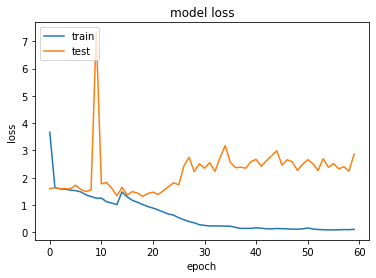

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
plt.savefig("loss.png")


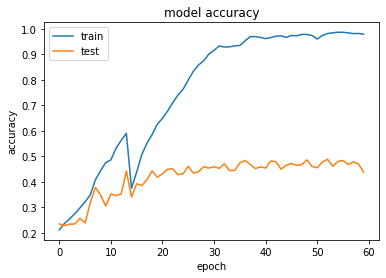

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
plt.savefig("accuracy.png")


accuracy 0.45913014046369943
precision 0.45913014046369943
recall 0.45854911452957736
f1 0.4569310752919922
matthews 0.3239132997058522
kappa 0.3237308362524679


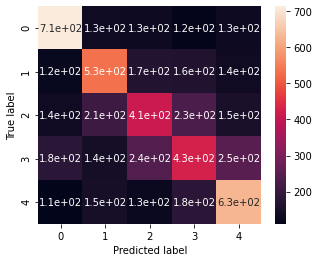

In [ ]:
from sklearn.metrics import matthews_corrcoef, precision_score, accuracy_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
 
accuracy = accuracy_score(y_score, y_pred)
precision = precision_score(y_score, y_pred, average='micro')
recall = recall_score(y_score, y_pred, average='macro')
f1 = f1_score(y_score, y_pred, average='weighted')
matthews = matthews_corrcoef(y_score, y_pred)
kappa_score = cohen_kappa_score(y_score, y_pred)
 
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_score, y_pred)
sns.heatmap(cm, annot=True)
#plt.title('kNN \nAccuracy:{​​​​​​​​0:.3f}​​​​​​​​'.format(accuracy_score(y_score, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion.png")
 
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1", f1)
print("matthews", matthews)
print("kappa", kappa_score)

